In [3]:
from generative.networks.schedulers import DDIMScheduler, DDPMScheduler

scheduler = DDIMScheduler(num_train_timesteps=1000)

isinstance(scheduler, DDPMScheduler)

False

# DDPM using MONAI generative model


In [1]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
# Set pwd directory

DATA_DIR = "/home/kdang/projects/spartDM/data/starmen/output_random_noacc"
os.chdir("/home/kdang/projects/spartDM/")
print("Current working directory:", os.getcwd())

Current working directory: /home/kdang/projects/spartDM


In [ ]:
from src.data import StarmenDataset

train_ds = StarmenDataset(data_dir=DATA_DIR, 
                            split="train", 
                            nb_subject=10,
                            save_data=False, 
                            workdir="workdir/test")
train_loader = DataLoader(train_ds, 
                            batch_size=2,
                            shuffle=True, 
                            num_workers=1)


val_ds = StarmenDataset(data_dir=DATA_DIR, 
                            split="val", 
                            nb_subject=10,
                            save_data=False, 
                            workdir="workdir/test")
val_loader = DataLoader(val_ds, 
                            batch_size=2,
                            shuffle=True, 
                            num_workers=1)


## Check the generative image from trained model

Setting: 

- step = 1000. 
- epoch = 100. 
- inferer_scheduler: DDPM. 


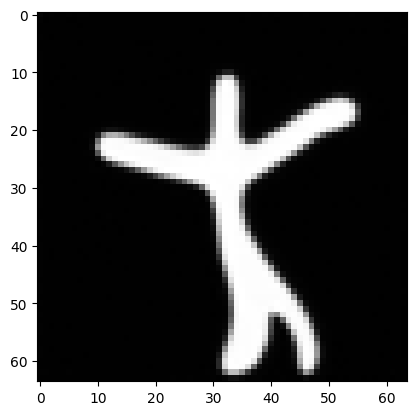

In [29]:
# Load sample image

sample_dir = os.path.join("workdir/monai_ddpm_2/samples", "sample_ep029.npy")

data = np.load(sample_dir).squeeze()

plt.imshow(data, cmap="gray")
plt.show()

## Sample from the trained model

### DDPM


In [16]:
# Define model and cheduler



device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    # norm_num_groups=16,
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=8,
)


ddpm_scheduler = DDPMScheduler(num_train_timesteps=1000)

ddpm_inferer = DiffusionInferer(ddpm_scheduler)

In [18]:
# Load pretrained model

trained_state = torch.load("workdir/monai_ddpm_2/ckpt/latest.pth", map_location=device)
trained_state.keys()

model.load_state_dict(trained_state["model_state"])
model.to(device)


DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

In [19]:
ddpm_scheduler.set_timesteps(num_inference_steps=1000)

In [20]:
# Sample using DDPM

sampling_steps = [1000]

noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
image, inter = ddpm_inferer.sample(input_noise=noise, 
                            diffusion_model=model, 
                            scheduler=ddpm_scheduler,
                            save_intermediates=True,
                            intermediate_steps=100)



100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


Text(0.5, 1.0, '1000 steps')

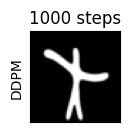

In [21]:
plt.figure(figsize=(8, 4))
plt.subplot(3, len(sampling_steps), 1)
plt.imshow(image.squeeze().cpu(), vmin=0, vmax=1, cmap="gray")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.ylabel("DDPM")
plt.title("1000 steps")

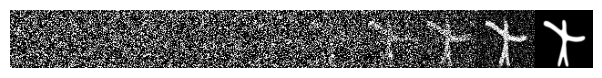

In [24]:
# Plot the generative process

from src.sadm.utils import plot_sample_process

plot_sample_process(start=None, inter=inter)

### DDIM

In [35]:
# Define DDIM scheduler

from generative.networks.schedulers import DDIMScheduler

ddim_scheduler = DDIMScheduler(num_train_timesteps=1000)

ddim_sample_steps = [1000, 500, 200, 50]
inferer = DiffusionInferer(scheduler=ddim_scheduler)

image_ddims = []
for i, step in enumerate(ddim_sample_steps):
    ddim_scheduler.set_timesteps(step)
    image_ddim, inter_ddim = inferer.sample(input_noise=noise, 
                           diffusion_model=model, 
                           scheduler=ddim_scheduler,
                           save_intermediates=True,
                           intermediate_steps=10)
    image_ddims.append(image_ddim)


100%|██████████| 50/50 [00:05<00:00,  8.43it/s]


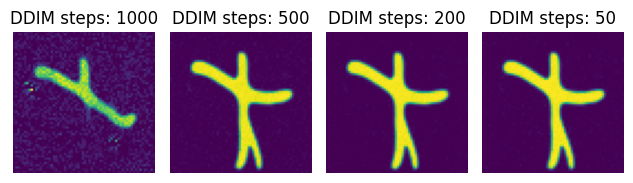

In [41]:
for i, img in enumerate(image_ddims): 
    plt.subplot(1, len(ddim_sample_steps), i+1)
    plt.imshow(img.squeeze().cpu(), vmin=0, vmax=1, cmap="viridis")
    plt.axis("off")
    plt.title(f"DDIM steps: {ddim_sample_steps[i]}")
    # plt.show()

plt.tight_layout()
plt.show()